## Book Recommendation Project

Recommendation Systems are one of the largest application areas of Machine Learning. They enable tailoring personalized content for users, thereby generating revenue for businesses

There are 2 main types of personalized recommendation systems:

### Content based filtering

   Recommendations are based on user's past likes/ dislikes & item feature space. The system makes recommendations which are similar to items the user has liked in the past. Items are considered similar based on item's features such as author, publisher, genre etc
    
    
### Collaborative based filtering

  Recommendations are based solely on user's past likes/ dislikes & how other users have rated other items. The system does not take into consideration an item's features like author, publisher, genre etc nor a user's features like age, gender, location etc. These take either a memory based approach or a model based approach

   **(1)Memory based approach**: Utilizes entire user-item rating information to calculate similarity scores between items or users for making recommendations. These are further either of 2 types:
    
   - __User based__: Two users are considered similar, if they rate items in a similar manner. An item is recommended to a user, if another user i.e., similar to the user in question has liked the item
           
   - __Item based__: Two items are considered similar, if users rate them in a similar manner. An item is recommended to a user, that is similar to the items the user has rated in the past
  
  
 
   **(2)Model based approach**: Utilizes user-item rating information to build a model & the model (not the entire dataset) is thereafter used for making recommendations. This approach is preferred in instances where time & scalability are a concern


This project aims to build a recommendation system based on collaborative filtering & will tackle an example of both memory based & model based algorithm

### Datasource: 

This project will use the 'Book-Crossing dataset' collected by Cai-Nicolas Ziegler (http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

The dataset consists of 3 different tables:
 - 'BX-Users': 278,858 records 
 - 'BX-Books': 271,379 records
 - 'BX-Book-Ratings' : 1,149,780 records 

In [33]:
# Libraries for data preparation & visualization
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "png"

# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# pip install scikit-surprise
# Importing libraries for model building & evaluation
# from sklearn.model_selection import train_test_split
# from surprise import Reader, Dataset
# from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
# from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
# from surprise import accuracy

In [34]:
import pandas as pd

# Read the 3 different csv files 
book = pd.read_csv('/Users/rabin/College_Project_Seven/Books.csv', low_memory=False)
rating = pd.read_csv('/Users/rabin/College_Project_Seven/Ratings.csv', encoding='latin-1', delimiter=';')
user = pd.read_csv('/Users/rabin/College_Project_Seven/Users.csv', encoding='latin-1', delimiter=';')


### Exploring 'Book-Rating'

In [35]:
rating.shape

(1149780, 3)

- There are 1,149,780 rows & 3 columns

In [36]:
rating.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [37]:
# Check datatypes & missing values
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


- There are no missing values

In [38]:
# Check for duplicate values
print(f'Duplicate entries: {rating.duplicated().sum()}')

Duplicate entries: 0


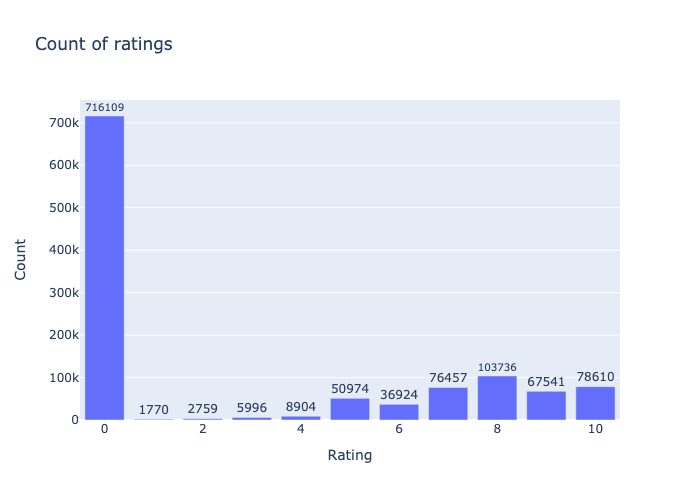

In [39]:
# Let's visualize the 'Book-Rating' column

rating_types = rating['Book-Rating'].value_counts()
x,y   = rating_types.index, rating_types.values
data  = go.Bar(x=x,y=y, text=y, textposition="outside")
Layout=go.Layout(title="Count of ratings",xaxis={'title':'Rating'},yaxis={'title':'Count'})
go.Figure(data,Layout)


Ratings are of two types, an implicit rating & explicit rating. An implicit rating is based on tracking user interaction with an item such as a user clicking on an item and in this case is recorded as rating '0'. An explicit rating is when a user explicitly rates an item, in this case on a numeric scale of '1-10'

- Majority of ratings are implicit i.e., rating '0'
- Rating of '8' has the highest rating count among explicit ratings '1-10'

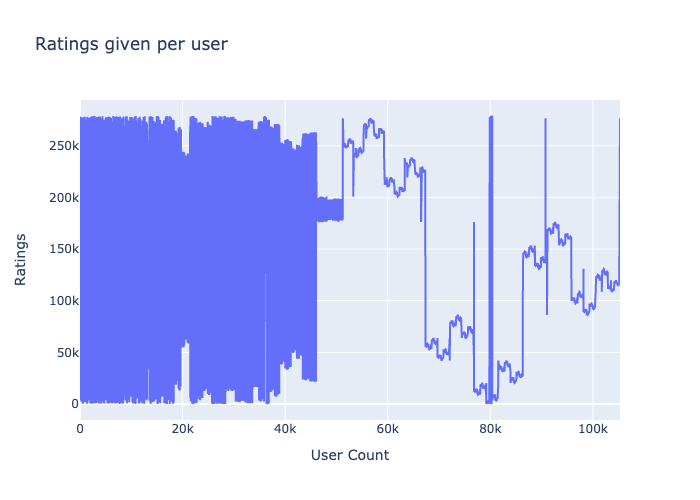

In [40]:
# Let's visualize ratings given by users

rating_users = rating['User-ID'].value_counts().reset_index().\
               rename({'Index':'User-ID','User-ID':'Rating'}, axis=1)

data  = go.Scatter(x = rating_users.index, y= rating_users['Rating'])
Layout= go.Layout(title="Ratings given per user",xaxis={'title':'User Count'}, yaxis={'title':'Ratings'})
go.Figure(data,Layout)


There is inherent bias in the dataset. There are few users who rate a lot & several users that provide very few ratings. One user has provided 13K+ ratings, only ~700 users (out of 100K+ users) have provided over 250 ratings

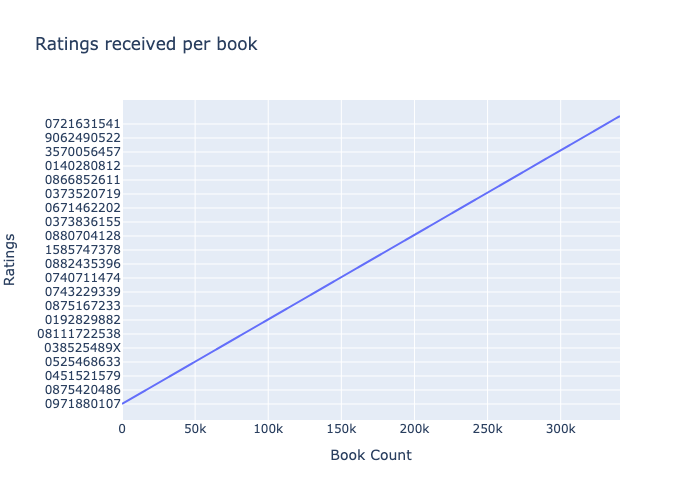

In [41]:
# Let's visualize ratings received by books

rating_books = rating['ISBN'].value_counts().reset_index().\
               rename({'Index':'ISBN','ISBN':'Rating'}, axis=1)

data  = go.Scatter(x = rating_books.index, y= rating_books['Rating'])
Layout= go.Layout(title="Ratings received per book",xaxis={'title':'Book Count'}, yaxis={'title':'Ratings'})
go.Figure(data, Layout)                            


A similar bias is observed. There are a few books that have received many ratings and several books that have received very few ratings. One book has received over 2500 ratings, only ~2100 books (out of 300K+ books) have received more than 50 ratings

In [42]:
# In order to avoid rating bias & for making good recommendations, limit the dataset to only those
# users that have made at least 250 ratings & books that have received at least 50 ratings
rating = rating[rating['User-ID'].isin(rating_users[rating_users['Rating'] > 250].index)]
rating = rating[rating['ISBN'].isin(rating_books[rating_books['Rating'] > 50].index)]

rating


TypeError: '>' not supported between instances of 'str' and 'int'

In [43]:
# For the recommendation system, it is prefered to have the book titles rather than ISBN for easier interpretation

rating = rating.merge(book, on="ISBN")[['User-ID','Book-Title','Book-Rating']] # merging with the book dataframe
rating                                                                         # on 'ISBN' to get 'Book-Title'

,User-ID,Book-Title,Book-Rating
0,2,Classical Mythology,0
1,8,Clara Callan,5
2,8,Decision in Normandy,0
3,8,Flu: The Story of the Great Influenza Pandemic...,0
4,8,The Mummies of Urumchi,0
...,...,...,...
385069,105266,The Da Vinci Code,7
385070,105274,The Never Ending Story,0
385071,105277,Banish Your Belly : The Ultimate Guide for Ach...,0
385072,105282,The Sparrow,0


- This has removed 534 records, possibly because there were some ISBN entries in the rating table that were not present in the book table. Finally, there are 79313 records

In [44]:
# Check for duplicate values
print(f'Duplicate entries: {rating.duplicated().sum()}')

Duplicate entries: 1306


Merging rating & book has introduced 531 duplicate records which will be dropped

In [45]:
rating.drop_duplicates(inplace=True)
rating

,User-ID,Book-Title,Book-Rating
0,2,Classical Mythology,0
1,8,Clara Callan,5
2,8,Decision in Normandy,0
3,8,Flu: The Story of the Great Influenza Pandemic...,0
4,8,The Mummies of Urumchi,0
...,...,...,...
385069,105266,The Da Vinci Code,7
385070,105274,The Never Ending Story,0
385071,105277,Banish Your Belly : The Ultimate Guide for Ach...,0
385072,105282,The Sparrow,0


- Finally, there are 78782 records

In [46]:
list_of_distinct_users = list(rating['User-ID'].unique())

### Machine Learning - Model Selection

In [50]:
# creating a surprise object
from surprise import Reader
from surprise import Dataset

# creating a surprise object
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(rating[['User-ID','Book-Title','Book-Rating']], reader)

reader = Reader(rating_scale=(0, 10))
data   = Dataset.load_from_df(rating[['User-ID','Book-Title','Book-Rating']], reader)


# Split the data into training & testing sets. Python's surprise documentation has the steps detailed out
# https://surprise.readthedocs.io/en/stable/FAQ.html

raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)                 # shuffle dataset

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold] # 80% of data is trainset
test_raw_ratings  = raw_ratings[threshold:] # 20% of data is testset

data.raw_ratings = train_raw_ratings        # data is now the trainset
trainset         = data.build_full_trainset() 
testset          = data.construct_testset(test_raw_ratings)

ModuleNotFoundError: No module named 'surprise'

Python's surprise library has several built-in algorithms for building rating based recommendation systems

#### KNN (K Nearest Neighbours), memory based approach
This algorithm takes into consideration up-to 'K' nearest users (in user based collaborative filtering) or 'K' nearest items (in item based collaborative filtering) for making recommendations. By default, the algorithm is 'user-based', and k is 40 (kmin is 1). This means ratings of 40 nearest users are considered while recommending an an item to a user. Some variants of this algorithm include WithMeans, WithZscore & Baseline wherein the average rating of users, or the normalized ZScores of ratings or the baseline rating are also considered as the system generates recommendations

#### SVD (Singular Value Decomposition), model based approach
This algorithm takes a matrix factorization approach. The user-item rating matrix is factorized into smaller dimension user & item matrices consisting of latent factors (hidden characteristics). By default, number of latent factors is 100. These latent factors are able to capture the known user-item rating preference & in the process  are able to predict an estimated rating for all user-item pair where user has not yet rated an item

In [51]:
# Trying KNN (K-Nearest Neighbors) & SVD (Singluar Value decomposition) algorithms using default model parameters

models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline(),SVD()] 
results = {}

for model in models:
    # perform 5 fold cross validation
    # evaluation metrics: mean absolute error & root mean square error
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    
    # storing the average score across the 5 fold cross validation for each model
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

NameError: name 'KNNBasic' is not defined

In [ ]:
performance_df = pd.DataFrame.from_dict(results)
print("Model Performance: \n")
performance_df.T.sort_values(by='RMSE')

- KNNWithMeans has the least RMSE (root mean square error) among KNN algorithms
- The model fit_time is the maximum for SVD but the model test_time is the least

### Machine Learning – Hyperparameter tuning with GridSearchCV

#### KNNWithMeans

- user_based: By default, this model parameter is 'True'. The other option 'False', corresponds to an item based approach
- min_support: This refers to number of items to consider (in user based approach) or number of users to consider (in item based approach) to calculate similarity before setting it to 0
- name: This refers to the distance measure that KNNWithMeans utilizes for calculating similarity. By default, the value is set as 'MSD' i.e., Mean Squared Distance. One other popular distance measure for rating based data is 'cosine' or angular distance. The cosine distance enables calculation of similarity among items & users accounting for inherent rating bias amongst users. E.g., users who like item2 twice as much as item1 may rate items as '8' & '4' if they are generous with their ratings but rate it only '4' & '2' if they are more stringent raters. MSD measures similarity based on the absolute ratings and will not be able to capture this inherent rating bias described above, however, cosine distance measure will be able to capture the same

In [ ]:
# Hyperparameter tuning - KNNWithMeans

param_grid = { 'sim_options' : {'name': ['msd','cosine'], \
                                'min_support': [3,5], \
                                'user_based': [False, True]}
             }

gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)
                                    
gridsearchKNNWithMeans.fit(data)

print(f'MAE Best Parameters:  {gridsearchKNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchKNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchKNNWithMeans.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchKNNWithMeans.best_score["rmse"]}\n')

- Post Hyperparameter Tuning with GridSearchCV, the best parameters are found to be different for MAE & RMSE metrics

- 'Cosine' distance measure, min_support of 3 & user_based : False i.e., item based approach have been chosen for building recommendations

The logic/code below can be modified to make recommendations using 'MSD' distance & user based method if needed

In [ ]:
# Model fit & prediction - KNNWithMeans

sim_options = {'name':'cosine','min_support':3,'user_based':False}
final_model = KNNWithMeans(sim_options=sim_options)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance:')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

- The MAE & RMSE metrics for testset are comparable with what was obtained using cross validation & hyperparameter tuning stages with trainset. Chosen model hence, generalizes well

#### SVD
- n_factors: This refers to number of latent factors (hidden characteristics) for matrix factorization/ dimensionality reduction. By default, the value is 100
- n_epochs: This refers to number of iterations of stochiastic gradient descent procedure, utilized by SVD for learning the parameters and minimizing error
- lr_all & reg_all: i.e., learning rate and regularization rate. Learning rate is the step size of the said (above) SGD algorithm whereas regularization rate prevents overlearning, so the model may generalize well on data it has not yet seen. By default these values are set as 0.005 & 0.02

In [ ]:
# Hyperparameter tuning - SVD

param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)
                                    
gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

- Post Hyperparameter Tuning with GridSearchCV, the best parameters are found to be different for MAE & RMSE metrics
- 'n_factors':50, 'n_epochs':10, 'lr_all':0.005 & 'reg_all': 0.2  have been chosen for building recommendations

In [ ]:
# Model fit & prediction - SVD

final_model = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all= 0.2)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

- The MAE & RMSE metrics for testset are comparable with what was obtained using cross validation & hyperparameter tuning stages with trainset. Chosen model hence again, generalizes well

### Building recommendations

In [ ]:
# Entire dataset will be used for building recommendations 

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(rating[['User-ID','Book-Title','Book-Rating']], reader)
trainset = data.build_full_trainset()

# A list of useful trainset methods are explained here: 
# https://surprise.readthedocs.io/en/stable/trainset.html

Two different functions are written to generate recommendations with the final chosen models KNNWithMeans & SVD

In [ ]:
# KNNWithMeans

def generate_recommendationsKNN(userID=13552, like_recommend=5, get_recommend =10):
    
    ''' This function generates "get_recommend" number of book recommendations using 
        KNNWithMeans & item based filtering. The function needs as input three 
        different parameters:
        (1) userID i.e., userID for which recommendations need to be generated 
        (2) like_recommend i.e., number of top recommendations for the userID to be 
        considered for making recommendations 
        (3) get_recommend i.e., number of recommendations to generate for the userID
        Default values are: userID=13552, like_recommend=5, get_recommend=10
    '''
    
    # Compute item based similarity matrix
    sim_options       = {'name':'cosine','min_support':3,'user_based':False}
    similarity_matrix = KNNWithMeans(sim_options=sim_options).fit(trainset).\
                        compute_similarities() 
    
    userID      = trainset.to_inner_uid(userID)    # converts the raw userID to innerID
    userRatings = trainset.ur[userID]              # method .ur takes user innerID & 
                                                   # returns back user ratings
    
    
    # userRatings is a list of tuples [(,),(,),(,)..]. Each tuple contains item & rating
    # given by the user for that item. Next, the tuples will be sorted within the list 
    # in decreasing order of rating. Then top 'like_recommend' items & ratings are extracted
    
    temp_df = pd.DataFrame(userRatings).sort_values(by=1, ascending=False).\
              head(like_recommend)
    userRatings = temp_df.to_records(index=False) 
    
    # for each (item,rating) in top like_recommend user items, multiply the user rating for
    # the item with the similarity score (later is obtained from item similarity_matrix) for
    # all items. This helps calculate the weighted rating for all items. The weighted ratings 
    # are added & divided by sum of weights to estimate rating the user would give an item
    
    recommendations   = {}

    for user_top_item, user_top_item_rating  in userRatings:

        all_item_indices          =   list(pd.DataFrame(similarity_matrix)[user_top_item].index)
        all_item_weighted_rating  =   list(pd.DataFrame(similarity_matrix)[user_top_item].values*\
                                          user_top_item_rating)
        
        all_item_weights          =   list(pd.DataFrame(similarity_matrix)[user_top_item].values)
        
        
        # All items & final estimated ratings are added to a dictionary called recommendations
        
        for index in range(len(all_item_indices)):
            if index in recommendations:
                # sum of weighted ratings
                recommendations[index] += all_item_weighted_rating[index]        
            else:                        
                recommendations[index]  = all_item_weighted_rating[index]

    
    for index in range(len(all_item_indices)):                               
            if all_item_weights[index]  !=0:
                # final ratings (sum of weighted ratings/sum of weights)
                recommendations[index]   =recommendations[index]/\
                                          (all_item_weights[index]*like_recommend)
                      

    # convert dictionary recommendations to a be a list of tuples [(,),(,),(,)]
    # with each tuple being an item & estimated rating user would give that item
    # sort the tuples within the list to be in decreasing order of estimated ratings

    temp_df = pd.Series(recommendations).reset_index().sort_values(by=0, ascending=False)
    recommendations = list(temp_df.to_records(index=False))
    
    # return get_recommend number of recommedations (only return items the user 
    # has not previously rated)
    
    final_recommendations = []
    count = 0
    
    for item, score in recommendations:
        flag = True
        for userItem, userRating in trainset.ur[userID]:
            if item == userItem: 
                flag = False       # If item in recommendations has not been rated by user, 
                break              # add to final_recommendations
        if flag == True:
            final_recommendations.append(trainset.to_raw_iid(item)) 
            count +=1              # trainset has the items stored as inner id,  
                                   # convert to raw id & append 
            
        if count > get_recommend:  # Only get 'get_recommend' number of recommendations
            break
    
    return(final_recommendations)

In [ ]:
recommendationsKNN = generate_recommendationsKNN(userID=13552, like_recommend=5, get_recommend=10)
recommendationsKNN

The above output shows the top 10 recommendations for userID 13552 based on the top 5 rated books of the user

In [ ]:
# SVD

def generate_recommendationsSVD(userID=13552, get_recommend =10):
    
    ''' This function generates "get_recommend" number of book recommendations 
        using Singular value decomposition. The function needs as input two 
        different parameters:
        (1) userID i.e., userID for which recommendations need to be generated 
        (2) get_recommend i.e., number of recommendations to generate for the userID
        Default values are: userID=13552, get_recommend=10
    '''
    
    model = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all= 0.2)
    model.fit(trainset)
    
    # predict rating for all pairs of users & items that are not in the trainset
    
    testset = trainset.build_anti_testset()
    predictions = model.test(testset)
    predictions_df = pd.DataFrame(predictions)
    
    # get the top get_recommend predictions for userID
    
    predictions_userID = predictions_df[predictions_df['uid'] == userID].\
                         sort_values(by="est", ascending = False).head(get_recommend)
    
    recommendations = []
    recommendations.append(list(predictions_userID['iid']))
    recommendations = recommendations[0]
    
    return(recommendations)

In [ ]:
recommendationsSVD = generate_recommendationsSVD(userID=13552, get_recommend =10)
recommendationsSVD

In [54]:
# Libraries for data preparation & visualization
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise import accuracy

pio.renderers.default = "png"

# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# Read the 3 different csv files 
book = pd.read_csv('/Users/rabin/College_Project_Seven/Books.csv', low_memory=False)
rating = pd.read_csv('/Users/rabin/College_Project_Seven/Ratings.csv', encoding='latin-1', delimiter=';')
user = pd.read_csv('/Users/rabin/College_Project_Seven/Users.csv', encoding='latin-1', delimiter=';')

# Let's visualize the 'Book-Rating' column
rating_types = rating['Book-Rating'].value_counts()
x, y = rating_types.index, rating_types.values
data = go.Bar(x=x, y=y, text=y, textposition="outside")
layout = go.Layout(title="Count of ratings", xaxis={'title': 'Rating'}, yaxis={'title': 'Count'})
fig = go.Figure(data, layout)
py.iplot(fig)

# Let's visualize ratings given by users
rating_users = rating['User-ID'].value_counts().reset_index().\
               rename({'index':'User-ID','User-ID':'Rating'}, axis=1)

data = go.Scatter(x=rating_users.index, y=rating_users['Rating'])
layout = go.Layout(title="Ratings given per user", xaxis={'title':'User Count'}, yaxis={'title':'Ratings'})
fig = go.Figure(data, layout)
py.iplot(fig)

# Let's visualize ratings received by books
rating_books = rating['ISBN'].value_counts().reset_index().\
               rename({'index':'ISBN','ISBN':'Rating'}, axis=1)

data = go.Scatter(x=rating_books.index, y=rating_books['Rating'])
layout = go.Layout(title="Ratings received per book", xaxis={'title':'Book Count'}, yaxis={'title':'Ratings'})
fig = go.Figure(data, layout)
py.iplot(fig)

# In order to avoid rating bias & for making good recommendations, limit the dataset to only those
# users that have made at least 250 ratings & books that have received at least 50 ratings
rating_users = rating['User-ID'].value_counts()
rating_books = rating['ISBN'].value_counts()

rating = rating[rating['User-ID'].isin(rating_users[rating_users > 250].index)]
rating = rating[rating['ISBN'].isin(rating_books[rating_books > 50].index)]

# For the recommendation system, it is preferred to have the book titles rather than ISBN for easier interpretation
rating = rating.merge(book, on="ISBN")[['User-ID', 'Book-Title', 'Book-Rating']]

# Check for duplicate values
print(f'Duplicate entries: {rating.duplicated().sum()}')
rating.drop_duplicates(inplace=True)

# Create surprise objects
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(rating[['User-ID','Book-Title','Book-Rating']], reader)

# Split the data into training & testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Trying KNN (K-Nearest Neighbors) & SVD (Singular Value Decomposition) algorithms using default model parameters
models = [KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD()] 
results = {}

for model in models:
    # Perform 5 fold cross validation
    # Evaluation metrics: mean absolute error & root mean square error
    CV_scores = cross_validate(model, data, measures=["MAE", "RMSE"], cv=5, n_jobs=-1)  
    
    # Storing the average score across the 5 fold cross validation for each model
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

performance_df = pd.DataFrame.from_dict(results)
print("Model Performance: \n")
print(performance_df.T.sort_values(by='RMSE'))

# Hyperparameter tuning - KNNWithMeans
param_grid = {'sim_options': {'name': ['msd', 'cosine'], 
                               'min_support': [3, 5], 
                               'user_based': [False, True]}
             }

gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)
gridsearchKNNWithMeans.fit(data)

print(f'MAE Best Parameters: {gridsearchKNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score: {gridsearchKNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchKNNWithMeans.best_params["rmse"]}')
print(f'RMSE Best Score: {gridsearchKNNWithMeans.best_score["rmse"]}\n')

# Model fit & prediction - KNNWithMeans
final_model_knn = KNNWithMeans(sim_options=gridsearchKNNWithMeans.best_params['rmse'])
final_model_knn.fit(trainset)
predictions_knn = final_model_knn.test(testset)

print('\nUnbiased Testing Performance for KNN:')
print(f'MAE: {accuracy.mae(predictions_knn)}, RMSE: {accuracy.rmse(predictions_knn)}')

# Hyperparameter tuning - SVD
param_grid_svd = {"n_factors": range(10, 100, 20),
                  "n_epochs": [5, 10, 20],
                  "lr_all": [0.002, 0.005],
                  "reg_all": [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid_svd, measures=['mae', 'rmse'], cv=5, n_jobs=-1)
gridsearchSVD.fit(data)

print(f'MAE Best Parameters: {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score: {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score: {gridsearchSVD.best_score["rmse"]}\n')

# Model fit & prediction - SVD
final_model_svd = SVD(n_factors=gridsearchSVD.best_params['rmse']['n_factors'], 
                      n_epochs=gridsearchSVD.best_params['rmse']['n_epochs'],
                      lr_all=gridsearchSVD.best_params['rmse']['lr_all'],
                      reg_all=gridsearchSVD.best_params['rmse']['reg_all'])


ModuleNotFoundError: No module named 'surprise'

The above output shows the top 10 recommendations for the same user 13552

### Comparing recommendations

- While the list of recommendations generated using KNNWithMeans & SVD are different (expected as they are different algorithms), there are some similarities in the generated lists too
- Both algorithms recommended instances of Harry Potter novels for user 13552. Additionally, the recommended books seem to be a similar genre lending confidence in interpretability of recommendations

### Conlusions & next steps

- We have successfully implemented a memory based as well as method based collaborative filtering approach to make recommendations in this project 
- In instances with a new user or new item where little is known of the rating preference, collaborative filtering may not be the method of choice for generating recommendations. Content based filtering methods may be more appropriate. Often, a hybrid approach is taken for building real time recommendations using multiple different approaches in industry! The project can be extended to build hybrid recommendation systems in the future